In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from numpy import recarray

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from torchvision import transforms
import torch.utils.data as data
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import os
import copy
import platform
import secrets
from collections import Counter

if torch.cuda.is_available():
    device = 'cuda'
    print('on cuda')
elif torch.backends.mps.is_available():
    device = 'mps'
    print('on mps')
else:
    device = 'cpu'
    print('on cpu')

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.mps.manual_seed(RANDOM_SEED)

on cuda


In [2]:
class Encoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):#, dropout_prob=0.2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=0.2,
        )
        
        self.fc = nn.Linear(num_layers, 1)

    def forward(self, x):
        
        outputs, (hidden, cell) = self.lstm(x.to(device))
        
        return outputs, (hidden, cell)


class Decoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=1):#, dropout_prob=0.2):
        
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        # self.dropout_prob = dropout_prob
        print("decoder layers: ", self.num_layers)
        
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=0.2,
        )
        self.fc = nn.Linear(
            hidden_size,
            output_size
        )

    def forward(self, x, hidden):
        
        hidden = (hidden[0], hidden[1])
        output, (hidden, cell) = self.lstm(x, hidden)
        prediction = self.fc(output)
        
        return prediction, (hidden, cell)
    
class Classifier(nn.Module):

  def __init__(self, input_dim=256, num_classes=13, num_units=64, dropout=0.5, hidden=True):
    super(Classifier, self).__init__()
    
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_dim, out_features=num_units),
        nn.ReLU(),
        nn.Linear(in_features=num_units, out_features=num_units),
        nn.ReLU(),
        nn.Linear(in_features=num_units, out_features=num_units),
        nn.ReLU(),
        nn.Linear(in_features=num_units, out_features=num_units),
        nn.ReLU(),
        nn.Linear(in_features=num_units, out_features=num_classes),
    )
    
  def forward(self, x):
    # print(type(x))
    return self.linear_layer_stack(x)

class LSTMVAE(nn.Module):
    """LSTM-based Variational Auto Encoder"""

    def __init__(self, input_size, hidden_size, latent_size, seq_len, num_layers, device):#, dropout_prob):
        """
        input_size: int, number of input features, default=3
        hidden_size: int, size of hidden layer, default=256
        latent_size: int, latent z-layer size, default=128
        seq_size: int, sequence length of input
        num_layers: int, number of layers in LSTM, default=2
        """
        super(LSTMVAE, self).__init__()
        self.device = device

        # init
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.seq_len = seq_len
        self.num_layers = num_layers
        # self.dropout_prob = dropout_prob

        # lstm ae
        self.lstm_enc = Encoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
        )
        
        self.lstm_dec = Decoder(
            input_size=latent_size,
            output_size=input_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
            # dropout=self.dropout_prob
        )
        
        self.classifier = Classifier()
        
        self.fc21 = nn.Linear(self.hidden_size, self.latent_size) #expected input: [64, 0]
        self.fc22 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = nn.Linear(self.latent_size, self.hidden_size)
        self.fc_fix = nn.Linear(self.seq_len * self.num_layers, self.seq_len)

    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std).to(self.device)

        z = mu + noise * std
        return z

    def forward(self, x):
        # print(x)
        batch_size, seq_len, feature_dim = x.shape

        # encode input space to hidden space
        outputs, enc_hidden = self.lstm_enc(x)
        enc_h = enc_hidden[0].view(self.num_layers, batch_size, self.hidden_size).to(self.device)

        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size
        h_ = self.fc3(z)

        # decode latent space to input space      
        z = z[0, :, :]
        
        #classifying based on latent layer 
        classification = self.classifier(enc_h)
        
        return classification
    
    def reconstruct(self, x):
        batch_size, seq_len, feature_dim = x.shape
        
        # encode input space to hidden space
        outputs, enc_hidden = self.lstm_enc(x)
        enc_h = enc_hidden[0].view(self.num_layers, batch_size, self.hidden_size).to(self.device)

        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size

        h_ = self.fc3(z)

        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len * self.num_layers, self.latent_size).to(self.device)
        hidden = (h_.contiguous(), h_.contiguous())
        reconstruct_output, hidden = self.lstm_dec(z, hidden)
        x_hat = reconstruct_output.squeeze()
        
        x_hat = self.fc_fix(x_hat)

        return x_hat
        
    def clf_loss(x, predictions, labels, class_weights):
        loss_fn = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
        return loss_fn(predictions, labels)

In [3]:
class mHealth(data.Dataset):

    def __init__(self, dataframe, labels):
        """
        Args:
            dataframe (pd.DataFrame): dataframe containing data
        """
        self.dataset = dataframe
        self.labels = labels

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Args:
            index (int): index
        Returns:
            (sequence, [128, 3])
            returns the time series data of length 128 in (X-axis, Y-axis, Z-axis)
        """
        #return sequence of length 128 x 3
        sequence = torch.tensor(self.dataset[index:index+128].to_numpy()).type(torch.float32) 
        sequence = sequence.unsqueeze(dim=1) #remove when using 3 dim, currently needed for 1 dim data
        
        #find the most common label in the labels array and make the sequence equal to that label
        # print(self.labels)
        count = Counter(self.labels.iloc[index:index+128])
        # print("count: ", count)
        # print(self.labels.iloc[index:index+128].value_counts())
        labels = count.most_common()[0]
        # labels = Counter(self.labels.iloc[index:index+128]).most_common(1)[0][0]
        # print("count: ", labels)
        
        return sequence, labels
    
def collate_fn(batch):

    labels = []
    for idx, d in batch:
        labels.append(torch.tensor(d[0]))
    
    labels = torch.tensor(labels)
    inputs = [torch.tensor(d[0]) for d in batch]
    inputs = pad_sequence(inputs, batch_first=True)

    return inputs, labels

0        -3.948768
1        -3.963551
2        -3.872089
3        -3.867484
4        -3.892834
            ...   
161275   -3.747522
161276   -3.804183
161277   -3.730558
161278   -3.392240
161279   -3.416911
Length: 161280, dtype: float64

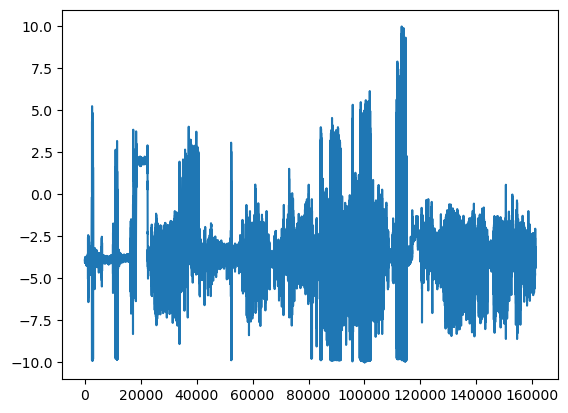

In [4]:
if(platform.system() == 'Darwin'):
    print('hi')

dataset_path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV\\mHealth_subject1.csv'

dataset = pd.read_csv(dataset_path)

labels = dataset['label']
dataset = dataset['chest acceleration X-axis'] #drop all columns that aren't chest accel info

dataset = dataset.to_numpy().reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-10, 10))

dataset = scaler.fit_transform(dataset)
dataset = pd.Series(dataset.squeeze())
plt.plot(dataset)
dataset

In [5]:
print(labels.value_counts())

label
0.0     126106
8.0       3379
1.0       3072
2.0       3072
3.0       3072
4.0       3072
6.0       3072
7.0       3072
9.0       3072
10.0      3072
11.0      3072
5.0       3072
12.0      1075
Name: count, dtype: int64


In [6]:
counter = Counter(labels)
class_counts = dict(sorted(counter.items(), key=lambda x: x[0]))
print("Sorted by Element:", class_counts)
# print(class_counts)

total_samples = len(labels)

NUM_CLASSES = 13
class_weights = []
for i in range(NUM_CLASSES):
    weight = total_samples / (NUM_CLASSES * class_counts[i])
    class_weights.append(weight)
    print("weight for", i, ": ", weight)
    # class_weights.append()

class_weights = torch.tensor(class_weights).to(device)
print(class_weights) 

Sorted by Element: {0.0: 126106, 1.0: 3072, 2.0: 3072, 3.0: 3072, 4.0: 3072, 5.0: 3072, 6.0: 3072, 7.0: 3072, 8.0: 3379, 9.0: 3072, 10.0: 3072, 11.0: 3072, 12.0: 1075}
weight for 0 :  0.098378775364803
weight for 1 :  4.038461538461538
weight for 2 :  4.038461538461538
weight for 3 :  4.038461538461538
weight for 4 :  4.038461538461538
weight for 5 :  4.038461538461538
weight for 6 :  4.038461538461538
weight for 7 :  4.038461538461538
weight for 8 :  3.671545974002322
weight for 9 :  4.038461538461538
weight for 10 :  4.038461538461538
weight for 11 :  4.038461538461538
weight for 12 :  11.540608228980322
tensor([ 0.0984,  4.0385,  4.0385,  4.0385,  4.0385,  4.0385,  4.0385,  4.0385,
         3.6715,  4.0385,  4.0385,  4.0385, 11.5406], device='cuda:0')


In [7]:
LOAD_MODEL = False
split_idx = int(len(dataset) * 0.8)

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)

print(labels[:split_idx].value_counts())
print('----------------------------------------------------------------')
print(labels[split_idx:].value_counts())

# train_set = mHealth(
#     dataframe=X_train,
#     labels = y_train
# )

# test_set = mHealth(
#     dataframe=X_test,
#     labels = y_test
# )

# training dataset
train_set = mHealth(
    dataframe=dataset[:split_idx],
    labels = labels[:split_idx]
)

test_set = mHealth(
    dataframe=dataset[split_idx:],
    labels = labels[split_idx:]
)

batch_size = 128
input_size = 1
hidden_size = 256
latent_size = 8
sequence_len = 128
num_layers = 2
clip_value = 10

# define LSTM-based VAE model
if(LOAD_MODEL):
    model = LSTMVAE(input_size, hidden_size, latent_size, sequence_len, num_layers, device=device)
    if(platform.system() == 'Darwin'):
        model.load_state_dict(torch.load('/Users/jm/VS Code/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/1_dim_4_layer_state_dict'))
    elif(platform.system() == 'Windows'):
        model.load_state_dict(torch.load('C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\VAE+RNN\\lstm_vae\\state_dicts\\untrained_32_latent_classifier'))
    else:
        model.load_state_dict(torch.load('/Users/jm/VS Code/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/1_dim_4_layer_state_dict'))
        print("linux")
    print("model loaded from state dict | system: ", platform.system())
else:
    model = LSTMVAE(input_size, hidden_size, latent_size, sequence_len, num_layers, device=device)

model.to(device)
print("training on: ", device)
print('----------------------------------------------------------------\n', 
      model)

label
0.0     96922
8.0      3379
1.0      3072
2.0      3072
3.0      3072
4.0      3072
6.0      3072
7.0      3072
9.0      3072
10.0     3072
11.0     3072
12.0     1075
Name: count, dtype: int64
----------------------------------------------------------------
label
0.0    29184
5.0     3072
Name: count, dtype: int64
decoder layers:  2
training on:  cuda
----------------------------------------------------------------
 LSTMVAE(
  (lstm_enc): Encoder(
    (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=2, out_features=1, bias=True)
  )
  (lstm_dec): Decoder(
    (lstm): LSTM(8, 256, num_layers=2, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=256, out_features=1, bias=True)
  )
  (classifier): Classifier(
    (linear_layer_stack): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_fe

In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=False
)

print(f"Dataloaders: {train_loader}")
print(f"Length of train_dataloader: {len(train_loader)} batches of {batch_size}")

temp_df = pd.DataFrame()
temp = []
for batch_data, label in train_loader:
    # print("data, ", labels[1].shape)
    print("datas shape: ", batch_data.shape)
    print("labels shape: ", label.shape)
    break
    

train_loss = []
test_loss = []
learning_rate = []
model_accuracy = []

# print(temp)

Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x000001C9BD64A010>
Length of train_dataloader: 1008 batches of 128
datas shape:  torch.Size([128, 128, 1])
labels shape:  torch.Size([128])


C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\2789512198.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in batch]


In [9]:
from sklearn.metrics import accuracy_score

def train(iterations, model, train_loader, test_loader):
    # optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    classifier_loss = torch.nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

    ## training
    
    for epoch in range(iterations):
        model.train()
        loop_train_loss = 0.0
        train_correct = 0
        train_total = 0
    
        optimizer.zero_grad()
        
        temp = -1
        
        for batch_data, label in train_loader:

            past_data = batch_data

            prediction = model(past_data)
            
            prediction = prediction[0, :, :]
            label = label.type(torch.LongTensor).to(device)
        
            clf_loss = model.clf_loss(prediction, label, class_weights)

            # Backward and optimize
            optimizer.zero_grad()
            clf_loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            
            optimizer.step()

        print({"train_loss": float(clf_loss)})
        temp = float(clf_loss)
                        
        if(temp != -1):
            train_loss.append(temp)
            
        before_lr = optimizer.param_groups[0]["lr"]
        learning_rate.append(float(before_lr))
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

        model.eval()
        eval_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_data, label in test_loader:
                past_data = batch_data
                
                label = label.to(device)
                
                prediction = model(past_data)
                
                prediction = prediction[0, :, :].to(device)
                # print(prediction.shape)
                # print(label.shape)
            
                clf_loss = model.clf_loss(prediction, label.type(torch.LongTensor).to(device), class_weights)

                eval_loss += clf_loss.item()
                
                val_total += label.size(0)
                _, predicted = torch.max(prediction, 1)
                val_correct += (predicted == label).sum().item()
                # val_total += 1
                # correct_preds = (predicted == label).float()
                # print('correct preds: ', correct_preds)
                
                # print("predicted shaep: ", predicted.shape)
                # print("label shape: ", label.shape)
                
                # print("accuracy: ", accuracy_score(predicted.cpu(), label.cpu()))
                # label = label.cpu().numpy()
                # label = pd.DataFrame(label)
                # print("label values: ", label.value_counts())
                

            print({"test_loss": float(clf_loss)})
            temp = float(clf_loss)
            
        if(temp != -1):
            test_loss.append(temp)
        eval_loss = eval_loss / len(test_loader)
        print("Evaluation Score : [{}]".format(eval_loss))
        # torch.cuda.empty_cache()
        print("val correct: ", val_correct)
        print("val total: ", val_total)
        accuracy = val_correct/val_total
        print("accuracy: ", accuracy )
        
        model_accuracy.append(accuracy)

    return model


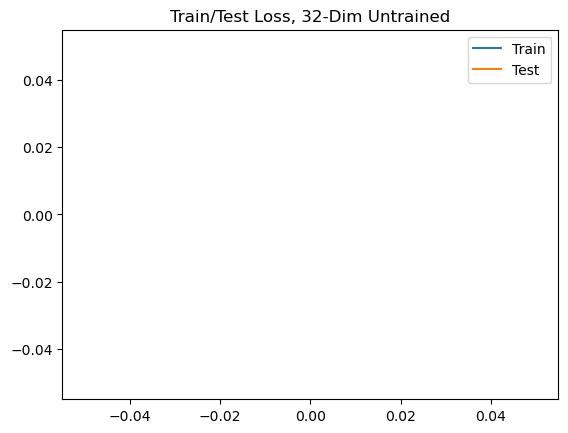

In [10]:
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label = "Test")
plt.title("Train/Test Loss, 32-Dim Untrained")
plt.legend()

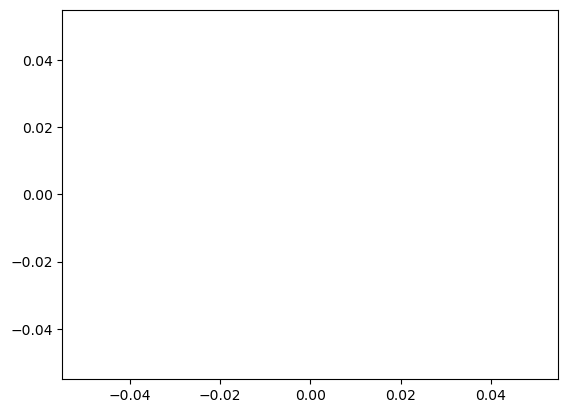

In [11]:
plt.plot(model_accuracy)

## Untrained Classifier/LSTM-VAE

In [12]:
class classifier_dataset(torch.utils.data.Dataset):

    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): dataframe containing data
        """
        self.dataset = dataframe['x-axis']
        # print(self.dataset)
        self.labels = dataframe['label']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Args:
            index (int): index
        Returns:
            (sequence, [128, 3])
            returns the time series data of length 128 in (X-axis, Y-axis, Z-axis)
        """
        #return sequence of length 128 x 3
        sequence = torch.tensor(self.dataset[index:index+128].to_numpy()).type(torch.float32) 
        sequence = sequence.unsqueeze(dim=1) #remove when using 3 dim, currently needed for 1 dim data
        
        label = torch.tensor(self.labels.iloc[index])

        return sequence, label

#pad sequences that aren't 128 length with 0's
def classifier_collate_fn(data):
    labels = []
    for d in data:
        labels.append(torch.tensor(d[1]))
    
    labels = torch.tensor(labels)
    inputs = [torch.tensor(d[0]) for d in data]
    inputs = pad_sequence(inputs, batch_first=True)

    return inputs, labels

In [13]:
X_train, X_test, y_train, y_test = [], [], [], []    
       
X = []
y = []

classifier_batch_size = 32

if(platform.system() == 'Windows'):
    partitioned_path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTH_PARTITIONED_CSV'
else:
    partitioned_path = '/home/jm/vscode/Python/pythonenv/gait-project/datasets/MHEALTHDATASET_CSV'

print(partitioned_path)

os.chdir(partitioned_path)

for file in os.listdir():
    if file.endswith(".csv"):
        
        file_path = partitioned_path +'\\'+file
        
        print("Current file: ", file_path)
        
        temp = pd.read_csv(file_path)
        
        temp = temp.sample(n=1000, random_state=42)

        x_data = temp
        y_data = temp['label'].to_numpy()
        
        split_idx = int(len(x_data) * 0.8)

        class_train = classifier_dataset(
            dataframe=x_data[:split_idx]
        )

        class_test = classifier_dataset(
            dataframe=x_data[split_idx:]
        )

        class_train_loader = torch.utils.data.DataLoader(
            class_train, 
            batch_size=1, 
            shuffle=True, 
            drop_last=True,
            collate_fn=classifier_collate_fn
            )

        class_test_loader = torch.utils.data.DataLoader(
            class_test, 
            batch_size=1, 
            shuffle=True, 
            drop_last=True,
            collate_fn=classifier_collate_fn
            )

        expected_shape = (1, 128, 1)
        for batch_idx, (inputs, targets) in enumerate(class_train_loader):

            if(inputs.shape != expected_shape):
                continue
            
            inputs = inputs.cuda()
            inputs = inputs.squeeze(dim=0)
            inputs = inputs.squeeze(dim=1)

            
            X.append(inputs)
            y.append(targets.cpu().detach())
            
        
        for batch_idx, (inputs, targets) in enumerate(class_test_loader):
            if(inputs.shape != expected_shape):
                continue
            
            inputs = inputs.cuda()
            inputs = inputs.squeeze(dim=0)
            inputs = inputs.squeeze(dim=1)
            
            X.append(inputs)
            y.append(targets.cpu().detach())
            

C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV
Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_arms.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_cycle.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_jog.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_jump.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_knee_bend.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_lying.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_null.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_run.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_sit.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_stairs.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_stand.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_waist_bend.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Current file:  C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTH_PARTITIONED_CSV\df_walk.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\25122671.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

class ClassifierDataset(Dataset):
    def __init__(self, data, labels):
        """
        Args:
            data (numpy.ndarray or list): The input data of shape (num_samples, input_size).
            labels (numpy.ndarray or list): The labels corresponding to the data, of shape (num_samples).
        """
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        temp_x = self.data[idx]

        return temp_x, self.labels[idx]

# Create the dataset
classifier_data = ClassifierDataset(X, y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
import torch
import torch.optim as optim
import torch.nn as nn

class_train_loss = []
class_test_loss = []
classifier_accuracy = []

def train_classifier(classifier, criterion, optimizer, num_epochs=10, device='cpu'):
    classifier.to(device)  # Move the model to the specified device (GPU or CPU)
    
    for epoch in range(num_epochs):
        classifier.train()  # Set the model to training mode
        running_loss = 0.0
        
        for inputs, labels in zip(X_train, y_train):
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            inputs = inputs.unsqueeze(dim=0)
            inputs = inputs.unsqueeze(dim=2)
            
            
            # Zero the parameter gradients
            optimizer.zero_grad()
                       
            # Forward pass
            outputs = model(inputs.to(device))
            
            outputs = outputs[0, :, :]

            loss = model.clf_loss(outputs, labels.type(torch.LongTensor).to(device), class_weights)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Accumulate the loss
            running_loss += loss.item() * inputs.size(0)
        
        # Calculate average loss over an epoch
        epoch_loss = running_loss / len(X_train)
        class_train_loss.append(epoch_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}')
        
        classifier.eval()  # Set the model to evaluation mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():  # Disable gradient calculation for evaluation
            for inputs, labels in zip(X_test, y_test):
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
                
                inputs = inputs.unsqueeze(dim=0)
                inputs = inputs.unsqueeze(dim=2)
            
                # Forward pass
                outputs = model(inputs.to(device))
                
                outputs = outputs[0, :, :]
                
                loss = model.clf_loss(outputs, labels.type(torch.LongTensor).to(device), class_weights)  # Compute the loss
                running_loss += loss.item() * inputs.size(0)  # Accumulate the loss
                _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()  # Count correct predictions
                
        avg_loss = running_loss / len(X_test)  # Average loss per batch
        class_test_loss.append(avg_loss)
        accuracy = correct / total  # Accuracy calculation
        classifier_accuracy.append(accuracy)
        print(f'Validation Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')
        
    print('Training complete')


In [17]:
LOAD_CLASSIFIER = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

if(LOAD_CLASSIFIER):
    model.load_state_dict(torch.load('C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\VAE+RNN\\lstm_vae\\state_dicts\\untrained_8_latent_layer_classifier'))
else:
    # Assuming train_loader is defined
    train_classifier(model, criterion, optimizer, num_epochs=20, device='cuda' if torch.cuda.is_available() else 'cpu')

    # torch.save(model.state_dict(), 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\VAE+RNN\\lstm_vae\\state_dicts\\untrained_8_latent_layer_classifier')

Epoch 1/20, Train Loss: 1.8163
Validation Loss: 1.2111, Test Accuracy: 0.4562
Epoch 2/20, Train Loss: 0.8474
Validation Loss: 0.4398, Test Accuracy: 0.7526
Epoch 3/20, Train Loss: 0.4932
Validation Loss: 0.2520, Test Accuracy: 0.8644
Epoch 4/20, Train Loss: 0.3132
Validation Loss: 0.2134, Test Accuracy: 0.8866
Epoch 5/20, Train Loss: 0.2619
Validation Loss: 0.1950, Test Accuracy: 0.8923
Epoch 6/20, Train Loss: 0.2865
Validation Loss: 0.1826, Test Accuracy: 0.8995
Epoch 7/20, Train Loss: 0.2453
Validation Loss: 0.1854, Test Accuracy: 0.9062
Epoch 8/20, Train Loss: 0.2260
Validation Loss: 0.1630, Test Accuracy: 0.9062
Epoch 9/20, Train Loss: 0.2277
Validation Loss: 0.1271, Test Accuracy: 0.9412
Epoch 10/20, Train Loss: 0.1689
Validation Loss: 0.0825, Test Accuracy: 0.9696
Epoch 11/20, Train Loss: 0.1529
Validation Loss: 0.0406, Test Accuracy: 0.9835
Epoch 12/20, Train Loss: 0.1095
Validation Loss: 0.0191, Test Accuracy: 0.9938
Epoch 13/20, Train Loss: 0.1035
Validation Loss: 0.0844, Test

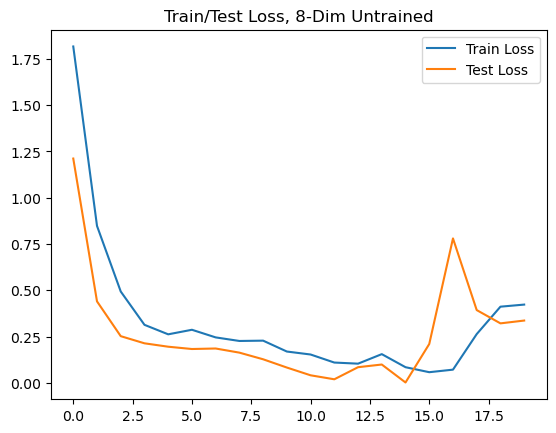

In [18]:
plt.plot(class_train_loss, label='Train Loss')
plt.plot(class_test_loss, label = 'Test Loss')
plt.title("Train/Test Loss, 8-Dim Untrained")
plt.legend()

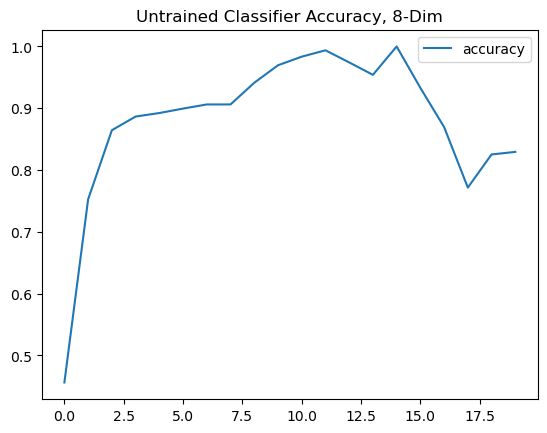

In [19]:
plt.plot(classifier_accuracy, label='accuracy')
plt.title("Untrained Classifier Accuracy, 8-Dim")
plt.legend()

In [20]:
def predict(model, dataloader):
    model.eval()
    all_outputs = []
    with torch.no_grad():
        for batch_data, label in dataloader:
            
            label = label.to(device)
            # print("I GOT HERE")

            x = batch_data  # Assuming batch is a tuple (data, target), adjust if necessary

            recon_x = model.reconstruct(x)

            recon_x = recon_x[:, 0]
            all_outputs.append(recon_x)
    return torch.cat(all_outputs, dim=0)

In [21]:
def plot_predictions(model):
    for i in range(10):

        path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV\\mHealth_subject' + str(i+1) + '.csv'
        df = pd.read_csv(path)
        
        df_labels = df['label']
        df = df['chest acceleration X-axis']
        
        
        df = df.to_numpy().reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(-10, 10))

        df = scaler.fit_transform(df)
        df = pd.Series(df.squeeze())
        
        dataset = mHealth(
            dataframe=df,
            labels=df_labels,
        )
        
        dataloader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=512,
            collate_fn=collate_fn,
            shuffle=False,
            drop_last=True
        )
        
        reconstructed_data = predict(model, dataloader)
        
        plt.figure(figsize=(16,5))
        plt.plot(df, label="True Data")
        plt.plot(reconstructed_data.cpu(), label="Reconstructed Data")
        plt.title("Recon Vs. True, Train Data")
        plt.legend()
                

In [22]:
from sklearn.metrics import accuracy_score, classification_report

predictions = []
with torch.no_grad():  # Disable gradient calculation for evaluation
    for inputs, labels in zip(X, y):
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
        
        
        inputs = inputs.unsqueeze(dim=0)
        inputs = inputs.unsqueeze(dim=2)
        
        # print("input shape: ",  inputs.shape)
        
    
        # Forward pass
        outputs = model(inputs.to(device))
        outputs = outputs[0, :, :]

        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        # print("predicted: ", predicted)
        predictions.append(predicted)
        

In [23]:
len(y)

9698

In [24]:
print(dict((i, y.count(i)) for i in y))

{tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746, tensor([7.], dtype=torch.float64): 746,

In [25]:
predictions = [tensor.item() for tensor in predictions]
float_list = y
float_list = [tensor.item() for tensor in float_list]
print(accuracy_score(float_list, predictions))
print(classification_report(float_list, predictions))

0.8267684058568777
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       746
         1.0       0.57      1.00      0.73       746
         2.0       0.74      0.46      0.57       746
         3.0       1.00      1.00      1.00       746
         4.0       0.51      0.99      0.67       746
         5.0       0.69      0.04      0.07       746
         6.0       1.00      1.00      1.00       746
         7.0       0.53      0.34      0.41       746
         8.0       0.95      0.99      0.97       746
         9.0       1.00      1.00      1.00       746
        10.0       1.00      1.00      1.00       746
        11.0       1.00      1.00      1.00       746
        12.0       1.00      1.00      1.00       746

    accuracy                           0.83      9698
   macro avg       0.84      0.83      0.80      9698
weighted avg       0.84      0.83      0.80      9698



C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\2789512198.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in batch]
C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\2789512198.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in batch]
C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\2789512198.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in batch]
C:\Users\Admin\AppData\Local\Temp\ipykernel_24052\2789512198.py:44:

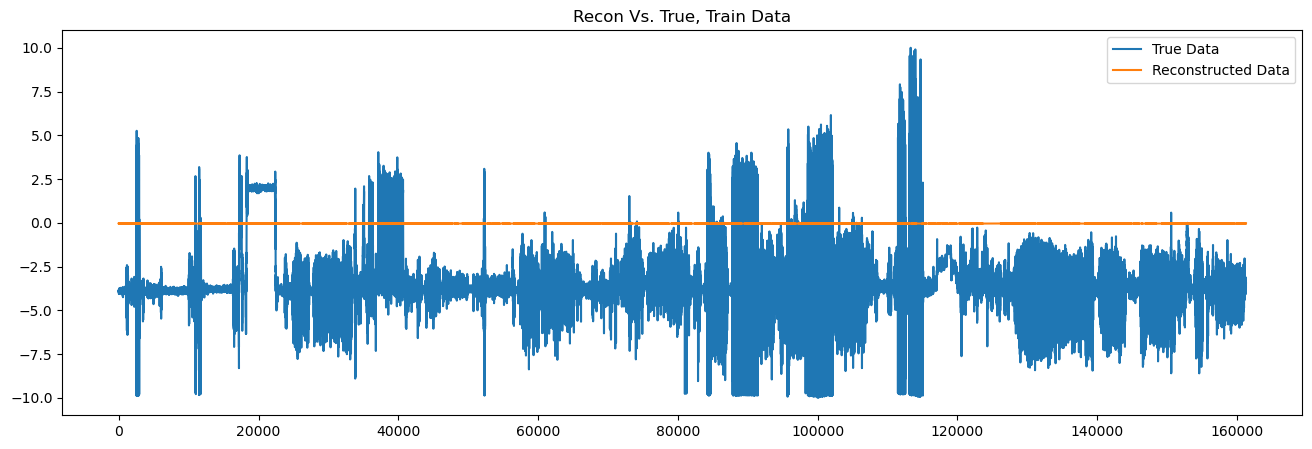

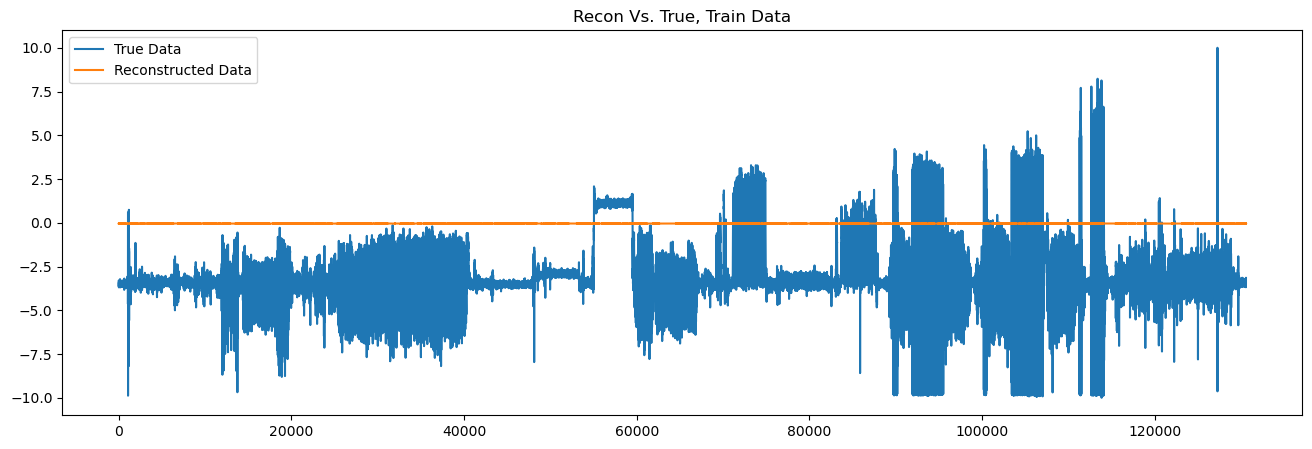

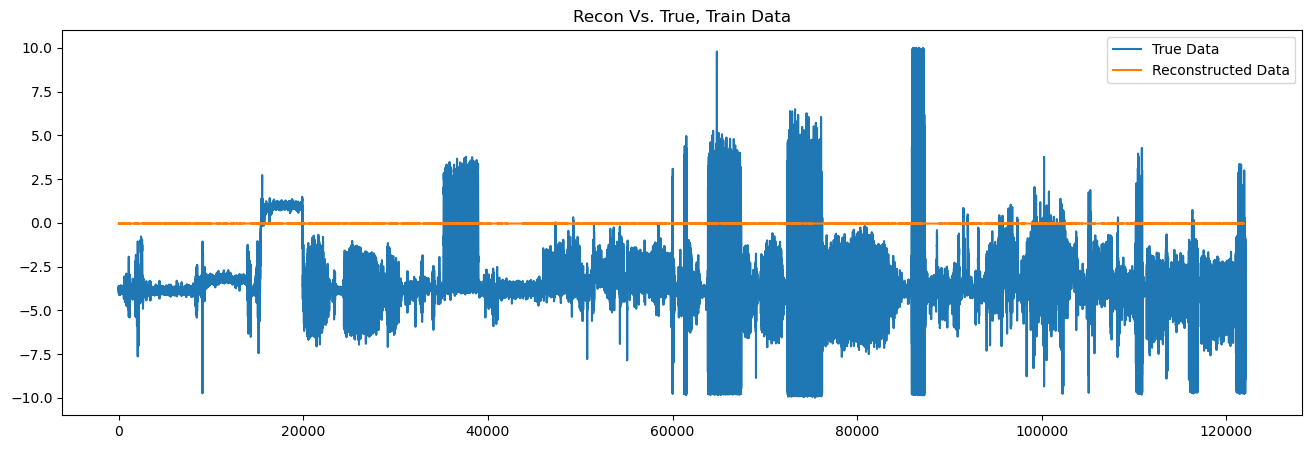

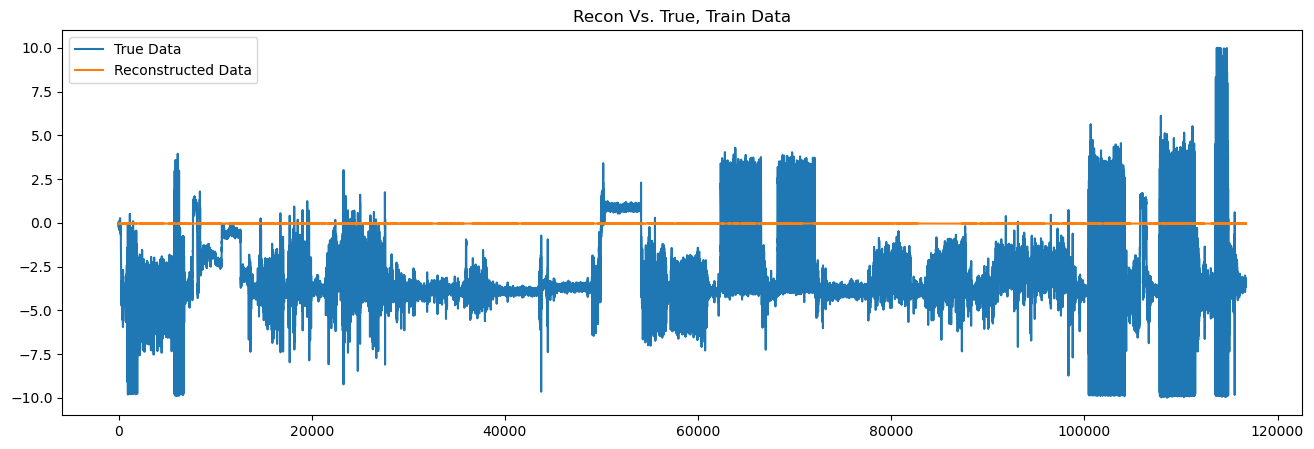

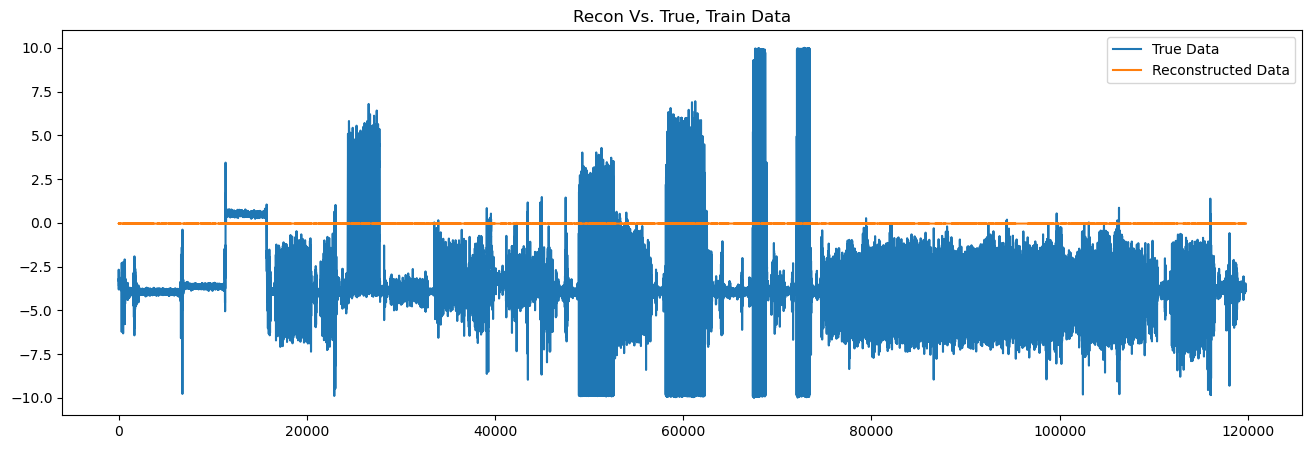

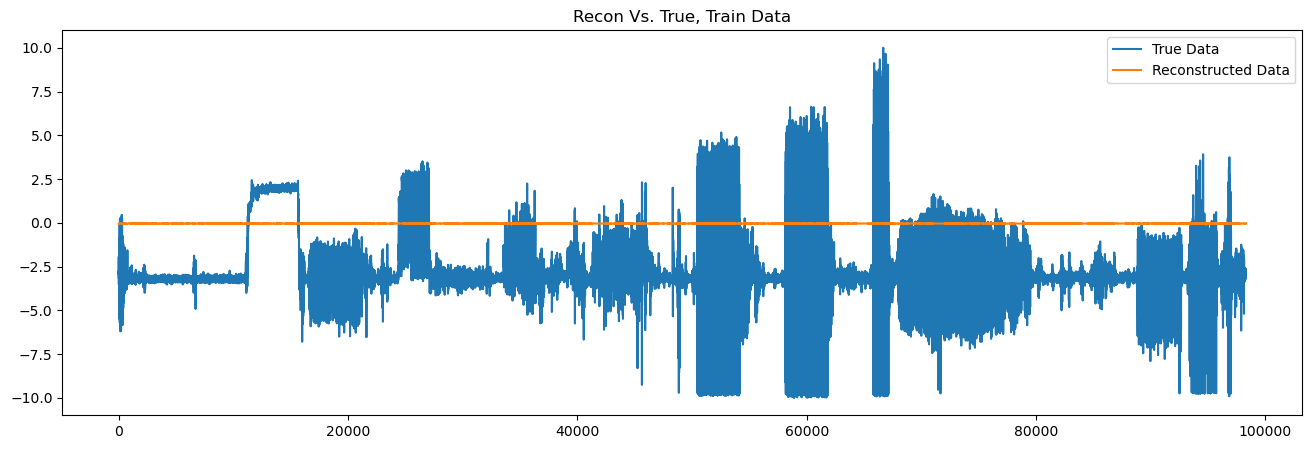

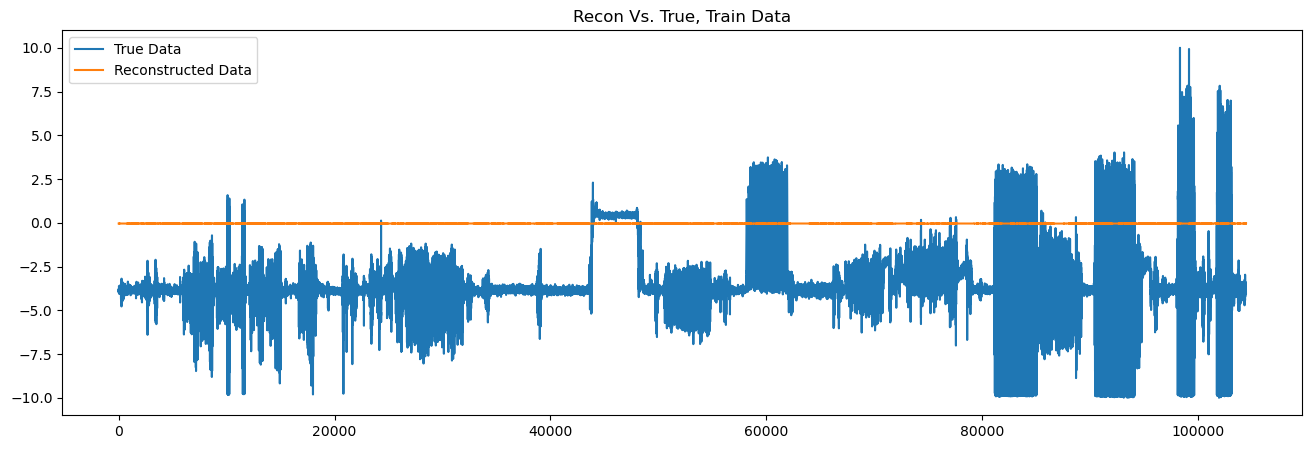

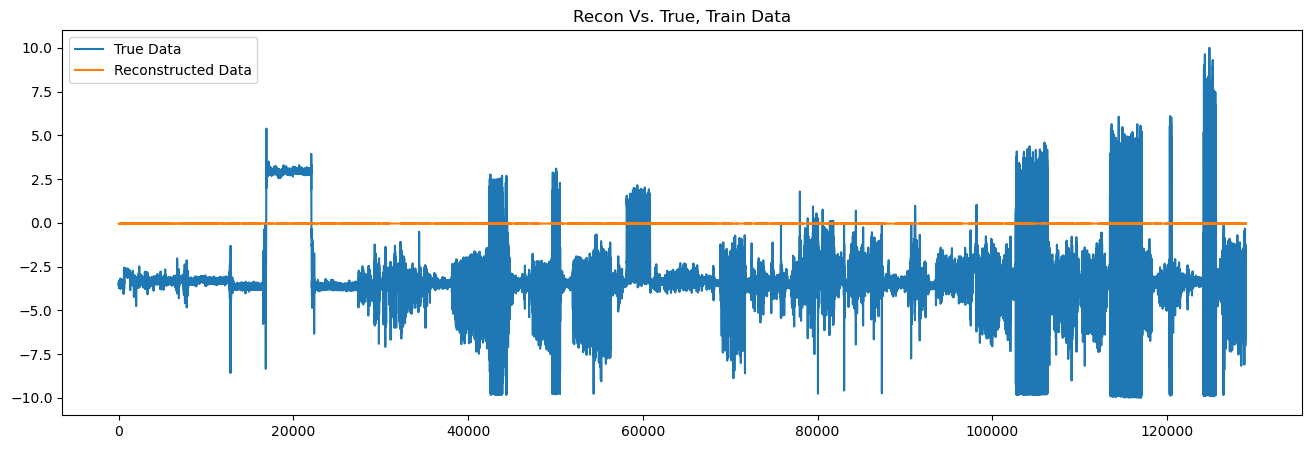

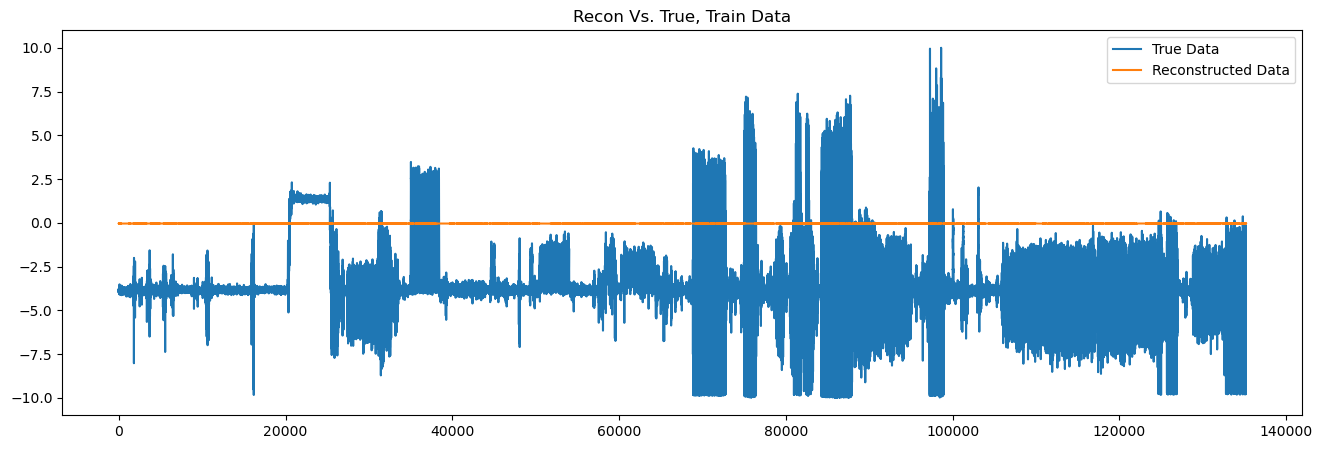

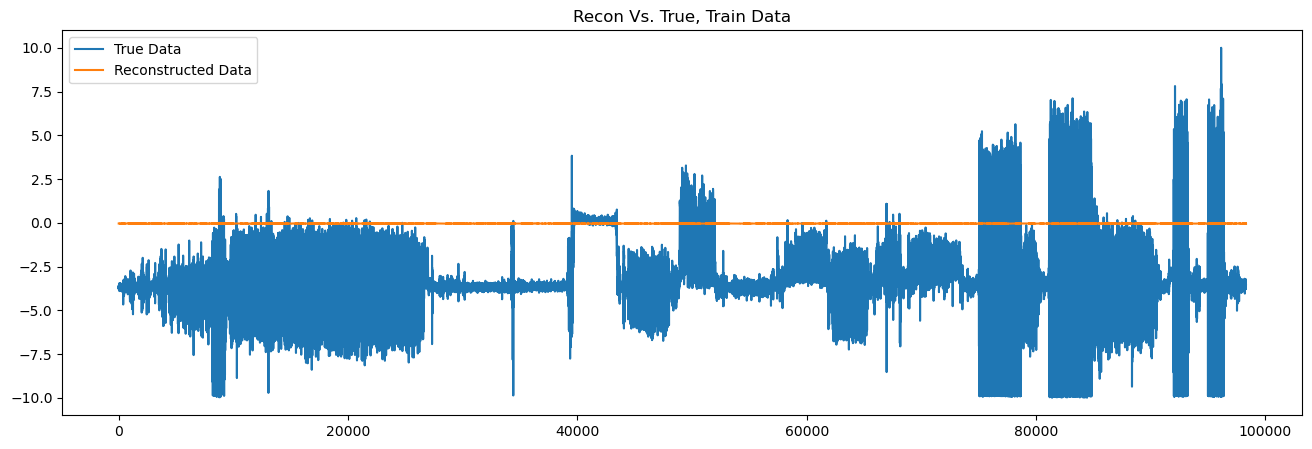

In [26]:
plot_predictions(model)